In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from numpy import loadtxt
import tensorflow as tf

In [2]:
bus = 73
samples = 20000
level = 95

Bus_data = loadtxt('BusData.dat')
Gen_data = loadtxt('GenData.dat')
Bra_data = loadtxt('BranchData.dat')

Pg_data   = loadtxt(('Pg_Profile_%d.csv' %bus), delimiter=',')
PF_data   = loadtxt(('PF_Profile_%d.csv' %bus), delimiter=',')
PD_data   = loadtxt(('PD_Profile_%d.csv' %bus), delimiter=',')
TC_data   = loadtxt(('TC_Profile_%d.csv' %bus), delimiter=',')

Pred_data = loadtxt(('Result/GNN_%d_PF_Predict_%d.csv' %(level, bus)), delimiter=',')

In [3]:
branch = Bra_data.shape[0]
index1 = int(0.8*samples)
index2 = int(0.1*samples)
index3 = index1 + index2

idxs = range(index3,samples)

In [4]:
# Verify label between prediction and test data
Label = np.zeros([index2,branch])
PF_Percent = PF_data[idxs] / Bra_data[:,5]

# Label each branch as either 1, 2, or 3
Label = (np.abs(PF_Percent) >= level/100 ) * 1# + \
# np.all([(np.abs(PF_Percent) <= 0.95),(np.abs(PF_Percent) > 0.75)], axis = 0) * 2 + \
# (np.abs(PF_Percent) > 0.95) * 3

print(index2 * branch - np.sum(Label+1 == Pred_data))

5852


In [5]:
#Only monitor branch that is in category 2
cat2_rate = Bra_data[Pred_data[1,:] == 2,:]
cat2_rate[:,0] = range(cat2_rate.shape[0])
print(cat2_rate[:,[0, 1, 5]])

# #Set PF to line limit for category 3
# cat3_rate = Bra_data[Pred_data[1,:] == 3,:]
# cat3_rate[:,0] = range(cat3_rate.shape[0])
# print(cat3_rate[:,1])

load_profile = PD_data[index3 + 1,:]
print(Pred_data[1,:])
a = np.sum(Pred_data == (2),axis = 1)
print(np.sum(a !=0 ))

[[  0.   7. 150.]
 [  1.  25. 225.]
 [  2.  29. 225.]
 [  3.  35. 350.]
 [  4.  44. 150.]
 [  5.  48. 150.]
 [  6.  54. 175.]
 [  7.  64. 225.]
 [  8.  78. 150.]
 [  9.  82. 150.]
 [ 10.  89. 200.]
 [ 11.  98. 225.]
 [ 12. 104. 350.]]
[1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 2. 1. 1. 1. 2. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 2.
 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 2. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1.
 1. 2. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1.]
2000


In [6]:
from pyomo.environ import *

# instance the pyomo abstract model
model = AbstractModel()

### Set
model.BUS    = Set(initialize = Bus_data[:,0]-1)                        #k
model.BRANCH = Set(initialize = Bra_data[:,0]-1)                        #j
model.GEN    = Set(initialize = Gen_data[:,0]-1)                        #i

def cat2_num(model):
    return cat2_rate[:,0]
model.BRALIM2 = Set(initialize = cat2_num)     #l

# def cat3_num(model):
#     return cat3_rate[:,0]
# model.BRALIM3 = Set(initialize = cat3_num)     #p

### Param
#Bus param = k
model.bus_num  = Param(model.BUS, initialize = Bus_data[:,1]-1)

load_profile = PD_data[0,:]
def bus_Pd(model, k):
    return load_profile[int(k)]
model.bus_Pd   = Param(model.BUS, initialize = bus_Pd)#, mutable = True)

model.bus_type = Param(model.BUS, initialize = Bus_data[:,3])


#Gen param = i
model.gen_num  = Param(model.GEN, initialize = Gen_data[:,1]-1)

model.gen_bus  = Param(model.GEN, initialize = Gen_data[:,2]-1)

model.gen_Pmax = Param(model.GEN, initialize = Gen_data[:,3])#, mutable=True)

model.gen_Pmin = Param(model.GEN, initialize = Gen_data[:,4])#, mutable=True)

model.gen_C    = Param(model.GEN, initialize = Gen_data[:,5])



#Branch param = j
model.branch_num   = Param(model.BRANCH, initialize = Bra_data[:,1]-1)

model.branch_fbus  = Param(model.BRANCH, initialize = Bra_data[:,2]-1)

model.branch_tbus  = Param(model.BRANCH, initialize = Bra_data[:,3]-1)

model.branch_x     = Param(model.BRANCH, initialize = Bra_data[:,4])

#Branch Limit 2 param = l
def num_rateA_2(model, l):
    return cat2_rate[int(l),1]-1
model.num_rateA_2   = Param(model.BRALIM2, initialize = num_rateA_2)#, mutable=True)

def branch_rateA_2(model, l):
    return cat2_rate[int(l),5]
model.branch_rateA_2 = Param(model.BRALIM2, initialize = branch_rateA_2)#, mutable=True)

# #Branch Limit 3 param = p
# def num_rateA_3(model, p):
#     return cat3_rate[int(p),1]-1
# model.num_rateA_3   = Param(model.BRALIM3, initialize = num_rateA_3)#, mutable=True)

# def branch_rateA_3(model, p):
#     return cat3_rate[int(p),5]
# model.branch_rateA_3 = Param(model.BRALIM3, initialize = branch_rateA_3)#, mutable=True)

#base MVA
model.Base = Param(default=100.0)
# model.BigM = Param(default=10000000)
# model.Mu   = 0.00001

### Var
model.bus_angle  = Var(model.BUS)
model.gen_supply = Var(model.GEN)
model.line_flow  = Var(model.BRANCH)
# model.u          = Var(model.BRALIM3, within=Binary)
# model.Pk1        = Var(model.BRALIM3)
# model.Pk2        = Var(model.BRALIM3)

### Objective function
def objfunction(model,i):
    totalcost = sum(model.gen_supply[i]*model.gen_C[i] for i in model.GEN) #* model.BaseMVA
    return totalcost

model.cost = Objective(rule=objfunction, sense=minimize)


### constraint
#Power balance equation
def PowerBal(model,k):
    buspower = sum(model.line_flow[j] for j in model.BRANCH if model.branch_tbus[j] == k) - sum(model.line_flow[j] for j in model.BRANCH if model.branch_fbus[j] ==k) + sum(model.gen_supply[i] for i in model.GEN if model.gen_bus[i]==k) - model.bus_Pd[k]
    return buspower == 0
model.cons_PowerBal = Constraint(model.BUS,rule=PowerBal)

#power output limitation for generator
def PGenMax(model,i):
    return model.gen_supply[i] <= model.gen_Pmax[i]
model.cons_PGenMax = Constraint(model.GEN,rule=PGenMax)
def PGenMin(model,i):
    return model.gen_Pmin[i] <=  model.gen_supply[i]
model.cons_PGenMin = Constraint(model.GEN,rule=PGenMin)


# line flow equation
def lineflow(model,j):
    return model.line_flow[j] == model.Base * ((model.bus_angle[model.branch_fbus[j]]-model.bus_angle[model.branch_tbus[j]])/model.branch_x[j])
model.cons_lineflow = Constraint(model.BRANCH, rule=lineflow)


# thermal constraint for category 2
def ThermalMax2(model,l):
    return model.line_flow[model.num_rateA_2[l]] <= model.branch_rateA_2[l]
model.cons_ThermalMax2 = Constraint(model.BRALIM2, rule=ThermalMax2)
def ThermalMin2(model,l):
    return -model.branch_rateA_2[l] <=  model.line_flow[model.num_rateA_2[l]] 
model.cons_ThermalMin2 = Constraint(model.BRALIM2, rule=ThermalMin2)

# def ThermalMax3(model,p):
#     return model.line_flow[model.num_rateA_3[p]] <= model.branch_rateA_3[p]
# model.cons_ThermalMax3 = Constraint(model.BRALIM3, rule=ThermalMax3)
# def ThermalMin3(model,p):
#     return -model.branch_rateA_3[p] <=  model.line_flow[model.num_rateA_3[p]] 
# model.cons_ThermalMin3 = Constraint(model.BRALIM3, rule=ThermalMin3)

# # set thermal constraint for category 3
# def ThermalMax3(model,p):
#     return model.Pk1[p] == model.branch_rateA_3[p] * model.u[p]
# model.cons_ThermalMax3 = Constraint(model.BRALIM3, rule=ThermalMax3)
# def ThermalMin3(model,p):
#     return model.Pk2[p] == model.branch_rateA_3[p] * (model.u[p]-1)
# model.cons_ThermalMin3 = Constraint(model.BRALIM3, rule=ThermalMin3)
# def Thermal3(model,p):
#     return model.Pk1[p] + model.Pk2[p] == model.line_flow[model.num_rateA_3[p]]
# model.cons_Thermal3 = Constraint(model.BRALIM3, rule=Thermal3)


In [7]:
# dcopf = model.create_instance()
# dcopf.cons_ThermalMax2.pprint()
# dcopf.pprint()


In [8]:
# form the pyomo data file
# form_data.formdata()
# instance according on the dat file

### set the solver
solver = SolverFactory('solver\gurobi.exe')
dcopf = model.create_instance()
results = solver.solve(dcopf, tee=False)

### Suppress infeasible error warning
import logging
logging.getLogger('pyomo.core').setLevel(logging.ERROR)

Pd_List = np.zeros([index2,Bus_data.shape[0]])
Pg_List = np.zeros([index2,Gen_data.shape[0]])
PF_List = np.zeros([index2,Bra_data.shape[0]])
TC_List = np.zeros([index2,1])
Optimal = np.zeros([index2,1])


In [9]:
import time

run = 1
total_t = np.zeros(run)


for t in range(run):
    
    SampleT = np.zeros([index2])
    ### Run solver to generate data samples
    m = index3
    n = 0

    while m < samples:

        #Only monitor branch that is in category 2  
        cat2_rate = Bra_data[Pred_data[n,:] == 2,:]
        cat2_rate[:,0] = range(cat2_rate.shape[0])    
        # cat3_rate = Bra_data[Pred_data[n,:] == 3,:]
        # cat3_rate[:,0] = range(cat3_rate.shape[0])   

        load_profile = PD_data[m,:]
        
        #Solving the model and record time
        dcopf = model.create_instance()
        start_t = time.time()
        results = solver.solve(dcopf, tee=False)
        stop_t = time.time()  
        SampleT[n] = stop_t - start_t
        
        if results.solver.termination_condition == "optimal":        
            Pg_List[n,:] = dcopf.gen_supply[:]()
            PF_List[n,:] = dcopf.line_flow[:]()
            TC_List[n,:] = dcopf.cost[:]()
            Optimal[n,:] = 1
        m = m+1
        n = n+1

        if m % 100 == 0:
            print(m)


     
    total_t[t] = np.sum(SampleT)
    #Total amount of time
    print('Total amount of time is', total_t[t])

18100
18200
18300
18400
18500
18600
18700
18800
18900
19000
19100
19200
19300
19400
19500
19600
19700
19800
19900
20000
Total amount of time is 125.40517234802246


In [10]:
np.mean(SampleT)

0.06270258617401123

In [11]:
print('Average amount of time:', np.mean(total_t))
print('Number of Solutions:', np.sum(Optimal))
print('Number of Constraint for Category 2:', np.mean(np.sum(Pred_data == 2, axis = 1)))

Average amount of time: 125.40517234802246
Number of Solutions: 2000.0
Number of Constraint for Category 2: 12.954


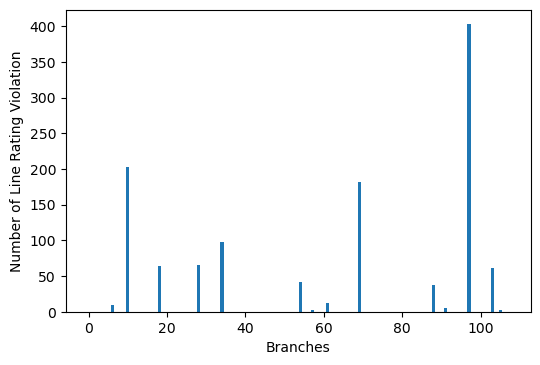

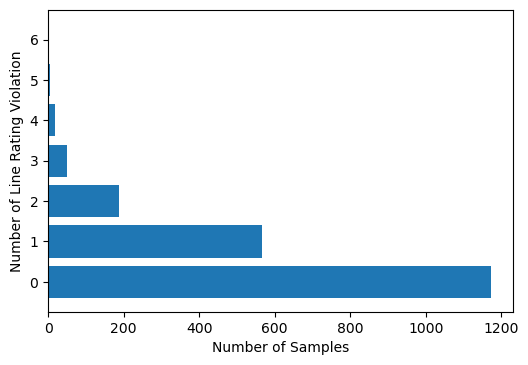

In [12]:
##Check how many branches violate line limit
bra_vio = np.abs(PF_List/Bra_data[:,5]) > 1

## Plot the number of branches violate line limit
plt.figure(dpi=100)      
plt.bar(range(branch), np.sum(bra_vio, axis = 0))
plt.xlabel("Branches")
plt.ylabel("Number of Line Rating Violation")
plt.savefig("Plot/GNN_{}_LR_Violation_Branches_{}.png".format(level, bus))

## Plot the number of branches violate line limit
plt.figure(dpi=100)      
plt.hist(np.sum(bra_vio, axis = 1), bins = [ 0, 1, 2, 3, 4, 5, 6, 7], align = 'left', rwidth = 0.8, orientation = 'horizontal')
plt.xlabel("Number of Samples")
plt.ylabel("Number of Line Rating Violation")
plt.savefig("Plot/GNN_{}_LR_Violation_Samples_{}.png".format(level, bus))

Average percentage of total cost for reduced OPF is 0.9992455335532467


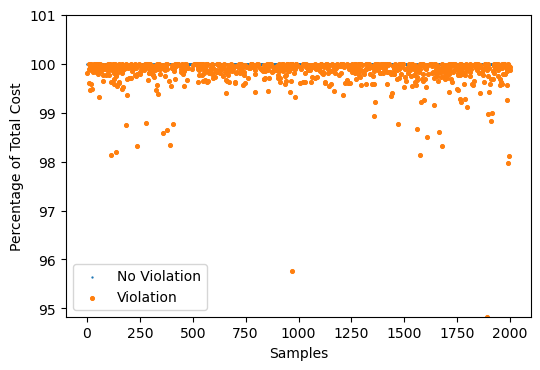

In [13]:
## Plot the percentage of total cost of reduced OPF compare to traditional OPF
cost_per = np.abs(np.squeeze(TC_List)/TC_data[idxs])

cost_over = cost_per[np.sum(bra_vio, axis = 1) != 0]
idxs_over = np.where(np.sum(bra_vio, axis = 1) != 0)
cost_undr = cost_per[np.sum(bra_vio, axis = 1) == 0]
idxs_undr = np.where(np.sum(bra_vio, axis = 1) == 0)

plt.figure(dpi=100)  
plt.scatter(idxs_undr,cost_undr*100, marker ="8", s = 0.5, label ="No Violation")
plt.scatter(idxs_over,cost_over*100, marker ="8", s = 8, label ="Violation")

plt.ylim(np.min(cost_per)*100,np.max(cost_per)*100 + 1)
plt.legend()
plt.xlabel("Samples")
plt.ylabel("Percentage of Total Cost")
plt.savefig("Plot/GNN_{}_Total_Cost_{}.png".format(level, bus))


print('Average percentage of total cost for reduced OPF is', np.mean(cost_per))


In [14]:
#Round up the highest probability value to 1, all other probability values are set to 0
def max_prob(probability):
    prob = probability.numpy()
    max_val = np.amax(prob,2,keepdims=1)
    prob[prob != max_val] = 0
    prob[prob == max_val] = 1
    return prob

#Find the error rate of final prediction
def err_rate(preds,targs):
    diff_rate = targs - preds
    x, y, z = diff_rate.shape
    diff_rate[diff_rate == 1] = 0
    return np.sum(np.abs(diff_rate)) / (x * y)

# # Find which categories and which branches are misidentified the most for 3 categories
# def err_stat(preds,targs):
#     diff_rate = targs - preds
    
#     x, y, z = diff_rate.shape 
#     cat = np.array([ [1, -1, 0] , [1, 0, -1] , [0, 1, -1] , [-1, 1, 0] , [0, -1, 1] , [-1, 0, 1] ])
#     err = np.zeros([diff_rate.shape[0],diff_rate.shape[1],6])
#     for i in range(diff_rate.shape[0]): 
#         for j in range(diff_rate.shape[1]): 
#             for k in range(6):        
#                 err[i,j,k] = np.array_equiv(cat[k],diff_rate[i,j])
#     cat_stat = np.sum(np.sum(err,axis = 0),axis = 0)               #Error rate across 6 categories
#     bra_stat = np.sum(np.sum(err,axis = 0),axis = 1)               #Error rate across all branches
#     sam_stat = np.sum(np.sum(err,axis = 1),axis = 1)               #Error rate across number of samples
#     return cat_stat, bra_stat, sam_stat

# Find which categories and which branches are misidentified the most for 2 categories
def err_stat(preds,targs):
    diff_rate = targs - preds
    
    x, y, z = diff_rate.shape 
    cat = np.array([ [1, -1] , [-1, 1] ])
    err = np.zeros([x,y,2])
    for i in range(diff_rate.shape[0]): 
        for j in range(diff_rate.shape[1]): 
            for k in range(2):        
                err[i,j,k] = np.array_equiv(cat[k],diff_rate[i,j])
    cat_stat = np.sum(np.sum(err,axis = 0),axis = 0)               #Error rate across 6 categories
    
    sam_stat = np.sum(np.sum(err,axis = 1),axis = 1)               #Error rate across number of samples
    
    bra1_stat = np.sum(err[:,:,0],axis = 0)                        #Error rate across all branches for category 1
    bra2_stat = -np.sum(err[:,:,1],axis = 0)                       #Error rate across all branches for category 2
    return cat_stat, bra1_stat, bra2_stat, sam_stat, err

In [15]:
test_prediction = tf.one_hot(Pred_data-1, depth = np.max(Pred_data))
test_target     = tf.one_hot(Label,       depth = np.max(Pred_data))

In [16]:
#Find the best probability of prediction for test data set:
pred = max_prob(test_prediction)
targ = tf.round(test_target).numpy()

[3017. 2835.]
[  0.   0.   0.   0.   0.   0. 241.   0.   0.   0. 280.   0.   0.   0.
   0.   0.   0.   4.  13.   0.   0.   0.   0.   0.   2.   0.   0.   0.
 442.   0.   0.   0.   0.   0. 416.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  45. 283.   0.
   0.   0.   0.   0.   0.  41.   0.  16.   0.   0.   0.   0.   0. 173.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0. 112. 148.   0.   0.   0.   0.   0.   0.   0.   0. 126.
   0.   0.   0.   0.   0. 675.   0.   0.   0.   0.]
[  -0.   -0.   -0.   -0.   -0.   -0. -186.   -0.   -0.   -0. -408.   -0.
   -0.   -0.   -0.   -0.   -0.  -27. -307.   -0.   -0.   -0.   -0.   -0.
   -0.   -0.   -0.   -0. -101.   -0.   -0.   -0.   -0.   -0. -264.   -0.
   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.
   -0.   -0.   -0.   -0.   -0.  -20.  -54.   -0.   -0.  -22.   -0.   -0.
   -0.  -80.   -0.   -0.   -0.   -0.   -0.   -0.   -0. -451.   -0.   -0.

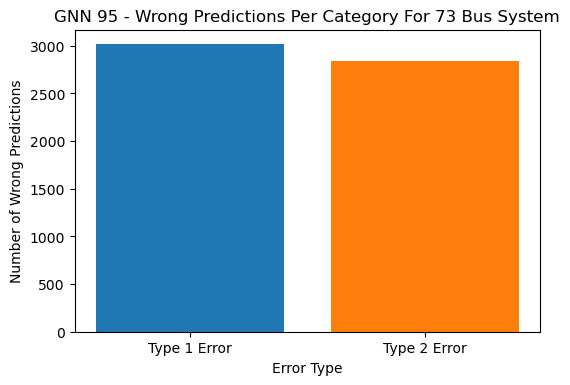

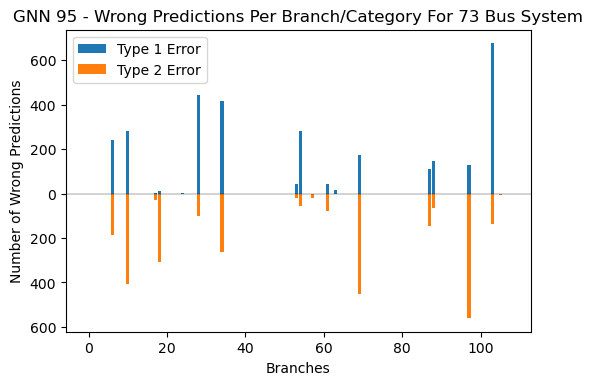

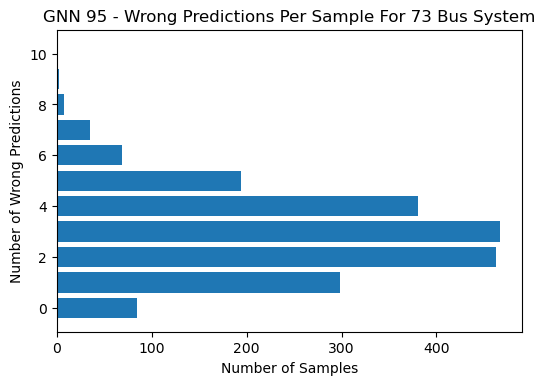

In [23]:
cat_err, bra1_err, bra2_err, sam_err, error = err_stat(pred, targ)

#Plot the number of wrong predictions per categories
# names = [ "1, -1, 0" , "1, 0, -1" , "0, 1, -1" , "-1, 1, 0" , "0, -1, 1" , "-1, 0, 1" ]
names = [ "Type 1 Error" , "Type 2 Error"]
print(cat_err)
plt.figure(dpi=100)      
plt.bar(names, cat_err, color =  [ '#1F77B4' , '#FF7F0E'])
plt.xlabel('Error Type')
plt.ylabel("Number of Wrong Predictions")
plt.title('GNN {} - Wrong Predictions Per Category For {} Bus System'.format(level, bus))
plt.savefig("Plot/GNN_{}_Categories_{}.png".format(level, bus))

#Plot the number of wrong predictions per branches
print(bra1_err)
print(bra2_err)
yname = np.abs(range(-600, 700, 200))
plt.figure(dpi=100) 
plt.bar(range(branch), bra1_err, label ="Type 1 Error")
plt.bar(range(branch), bra2_err, label ="Type 2 Error")
plt.axhline(y=0, xmin=-10, xmax=150, linewidth = 0.25, color = 'black')
plt.yticks(ticks=range(-600, 700, 200), labels = yname)
plt.legend()
plt.xlabel('Branches')
plt.ylabel("Number of Wrong Predictions")
plt.title('GNN {} - Wrong Predictions Per Branch/Category For {} Bus System'.format(level, bus))
plt.savefig("Plot/GNN_{}_Branches_{}.png".format(level, bus))

#Plot histogram of how many wrong predictions per number of samples
plt.figure(dpi=100) 
plt.hist(sam_err, bins = range(12), align = 'left', rwidth = 0.8, orientation = 'horizontal')
plt.xlabel("Number of Samples")
plt.ylabel("Number of Wrong Predictions")
plt.title('GNN {} - Wrong Predictions Per Sample For {} Bus System'.format(level, bus))
plt.savefig("Plot/GNN_{}_Historgram_{}.png".format(level, bus))

#Total number of wrong predictions and error rates
print('Number of wrong predictions is ', np.sum(cat_err))
print('Error rate is ', err_rate(pred, targ))

In [18]:
# Calculate statistical data if there are branch violations

if np.sum(bra_vio) > 0:
    Per_data = np.abs(PF_List/Bra_data[:,5])
    Indices  = np.where(Per_data > 1)
    Per_data = Per_data[bra_vio] * 100
    Per_mean = np.mean(Per_data)
    Per_max  = np.max(Per_data)
    Per_min  = np.min(Per_data)
    Per_std  = np.std(Per_data)
    Per_med  = np.median(Per_data)
    
    MW_data = (np.abs(PF_List)-Bra_data[:,5])[bra_vio]
    MW_mean = np.mean(MW_data)
    MW_max  = np.max(MW_data)
    MW_min  = np.min(MW_data)
    MW_std  = np.std(MW_data)
    MW_med  = np.median(MW_data)
    
    import pandas as pd
    df_Per = pd.DataFrame(np.transpose([Indices[0],Indices[1],Per_data]), columns = ['Number', 'Branch', 'Percent Value'])
    df_MW  = pd.DataFrame(np.transpose([Indices[0],Indices[1],MW_data]),  columns = ['Number', 'Branch', 'MW Value'])
    df_cat  = pd.DataFrame(np.concatenate([np.transpose([Indices[0],Indices[1]]), error[Indices[0],Indices[1],:]],axis = 1),  columns = ['Number', 'Branch', 'Category 1', 'Category 2'])
    df_stat = pd.DataFrame( [[Per_mean,Per_max,Per_min,Per_std,Per_med], [MW_mean,MW_max,MW_min,MW_std,MW_med]], index=['Percent', 'MW'], columns = ['Mean', 'Max', 'Min', 'Sta. Dev.', 'Median'])
    print(df_stat)


    # Write data into Excel sheet
    with pd.ExcelWriter(('Result/Level_GNN_%d.xlsx' %(level))) as writer:
        df_stat.to_excel(writer, sheet_name='Statistic')
        df_cat.to_excel (writer, sheet_name='Categories Error')
        df_Per.to_excel( writer, sheet_name='Percent_Data')
        df_MW.to_excel(  writer, sheet_name='MW_Data')

               Mean         Max         Min  Sta. Dev.      Median
Percent  105.546682  127.103815  100.011373   4.549584  104.443224
MW        13.460758   94.863352    0.017060  12.118936   10.168154


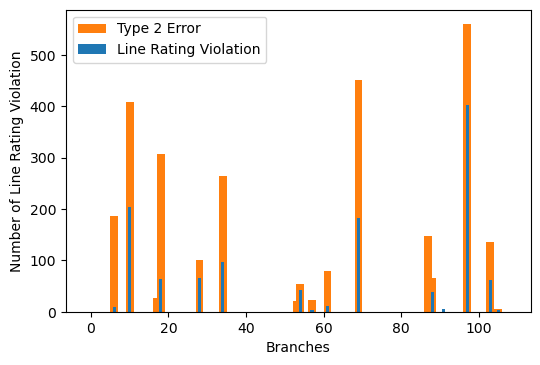

In [19]:
plt.figure(dpi=100)  
plt.bar(range(branch), -bra2_err, label ="Type 2 Error", color = '#FF7F0E', width = 2)
plt.bar(range(branch), np.sum(bra_vio, axis = 0), label ="Line Rating Violation", color = '#1F77B4')
plt.legend()
plt.xlabel("Branches")
plt.ylabel("Number of Line Rating Violation")
plt.savefig("Plot/GNN_{}_LR_Violation_Type_2_Branches_{}.png".format(level, bus))
 